In [3]:
%pylab inline
from tensorflow.keras.datasets import mnist
from tqdm import trange

Populating the interactive namespace from numpy and matplotlib


In [4]:
import pickle

In [5]:
poka = lambda x : imshow(x, cmap=cm.gist_gray_r)

In [41]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
pat_num=100
x_train=x_train.astype('float64')[:pat_num]
y_train=y_train[:pat_num]
x_test=x_test.astype('float64')

In [42]:
x_train.shape

(100, 28, 28)

# CNN - ver. 0.1 (no backprop)

In [43]:
filters=array([
    [
        # krawędzie pionowe prawe
        [-1,1,0],
        [-1,1,0],
        [-1,1,0]
    ],
    [
        # krawędzie pionowe lewe
        [1,-1,0],
        [1,-1,0],
        [1,-1,0]
    ],
    [
        [-1, -1, -1],
        [ 1,  1,  1],
        [ 0,  0,  0]
    ],
    [
        [ 1,  1,  1],
        [-1, -1, -1],
        [ 0,  0,  0]
    ]
])

In [44]:
def overlapping_regions(image, n):
    w, h = image.shape
    for x in range(w-n+1):
        for y in range(h-n+1):
            yield image[x:x+n, y:y+n], x, y

def nonoverlapping_regions(image, n):
    w, h = image.shape
    for i in range(0,h,n):
        for j in range(0,w,n):
            yield image[i:i+n,j:j+n], i, j  

In [45]:
def conv(image, kernel):
    n=kernel.shape[0]
    w, h = image.shape
    result=zeros((w-n+1, h-n+1))
    for reg, i, j in overlapping_regions(image, n):
        result[i,j]=sum(reg*kernel)
    return result

def relu(x):
    return maximum(x,0)

def maxpooling(image, n):
    w, h = image.shape
    nw, nh = int(ceil(w/n)), int(ceil(h/n))
    result=zeros(nw*nh)
    k=0
    for reg, i, j in nonoverlapping_regions(image, n):
        result[k]=reg.max()
        k+=1       
    return result.reshape(nw, nh)

In [46]:
def forward(im):
    im = maxpooling(im,2)
    c = array([relu(conv(im,f)) for f in filters])
    c = array([maxpooling(im,2) for im in c])
    c=c.flatten()
    c /= c.max() 
    c -= 0.5
    return c    

In [47]:
in_layer=[]
for i in trange(pat_num):
    im = x_train[i]
    in_layer.append(forward(im))
in_layer=array(in_layer)

100%|██████████| 100/100 [00:00<00:00, 152.46it/s]


In [48]:
in_layer.shape

(100, 144)

In [49]:
# pickle.dump(in_layer, open('in_layer_10k.p', 'wb'))

In [50]:
class Dense:
    def __init__(self, inputs, outputs):
        self.s=zeros(outputs)
        self.h=zeros(outputs)
        self.bias=normal(0, 1, outputs)
        self.w=normal(0, 1, (inputs, outputs))
        
    def f(self, x):
        '''Activation function'''
        return 1/(1+exp(-x))

    def df(self, x):
        '''Derivative of activation function'''
        y=self.f(x)
        return y*(1-y)

    def forward(self, inp):
        self.s=inp
        self.h=self.s @ self.w + self.bias
        return self.f(self.h)

    
    def backward(self, diff, learning_rate):
        delta=self.df(self.h)*diff
        self.w+=learning_rate * outer(self.s, delta)
        self.bias+=learning_rate*delta
        return self.w @ delta

In [51]:
class mlp:
    def __init__(self):
        self.l1=Dense(144, 50)
        self.l2=Dense(50, 10)

    def eval(self,x):
        x=self.l1.forward(x)
        x=self.l2.forward(x)
        return self.softmax(x)
        
    def softmax(self, x):
        x=exp(x)
        x/=sum(x)        
        return x
        
    def epoch(self, X, Y, learning_rate):
        err=0
        p_num=X.shape[0]
        for p in random.permutation(p_num):
            x=self.l1.forward(X[p])
            x=self.l2.forward(x)
            diff=eye(10)[Y[p]]-x
            d=self.l2.backward(diff, learning_rate)
            self.l1.backward(d, learning_rate)        
            err+=sum(diff*diff)/2
        return err

In [52]:
m=mlp()
hist=[]

In [53]:
eta=0.1
for epoch in trange(500):
    hist.append(m.epoch(in_layer, y_train, eta))
print(hist[-1]) 

100%|██████████| 500/500 [00:06<00:00, 81.30it/s]

6.712185480881779


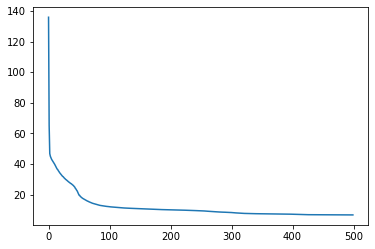

In [54]:
plot(hist)

In [55]:
ok=0
for i in trange(in_layer.shape[0]):
    if(argmax(m.eval(in_layer[i]))==y_train[i]):
        ok+=1
print(ok)   

100%|██████████| 100/100 [00:00<00:00, 20933.84it/s]

87


In [56]:
num=x_test.shape[0]
num=100

ok=0
for i in trange(num):
    im=x_test[i]
    if(argmax(m.eval(forward(im)))==y_test[i]):
        ok+=1
print(ok) 

100%|██████████| 100/100 [00:00<00:00, 142.47it/s]

69


In [57]:
# save
pickle.dump(m, open('mnist_cnn.p', 'wb'))